# Kriging Example 2¶

Author: Mohit S. Chauhan Date: Aug 20, 2018

In this example, Kriging is used to generate a surrogate model for a given data. In this data, sample points are generated using STS class and functional value at sample points are estimated using a model defined in python script ('python_model_function.py).

Import the necessary libraries. Here we import standard libraries such as numpy and matplotlib, but also need to import the STS, RunModel and Krig class from UQpy.

https://al-roomi.org/benchmarks/unconstrained/2-dimensions/134-jennrich-sampson-s-function

In [1]:
from UQpy.Surrogates import Krig
from UQpy.SampleMethods import STS
from UQpy.RunModel import RunModel
from Jennrich_Sampson import jenn_sam
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits import mplot3d

Using UQpy STS class to generate samples for two random variables, which are uniformly distributed between 0 and 1.

In [2]:
x = STS(dimension=2, dist_name=['Uniform', 'Uniform'], dist_params=[[-1, 2], [-1, 2]], sts_design=[14, 14])


UQpy: Successful execution of STS design..


RunModel is used to evaluate function values at sample points. Model is defined as a function in python file 'python_model_function.py'.

In [3]:
rmodel = RunModel(model_script='Jennrich_Sampson.py', verbose=True)
rmodel.run(samples=x.samples)

No samples. Creating the object alone.
The model function that will be run: jenn_sam

Performing serial execution of the model without template input.



Using UQpy Krig class to generate a surrogate for generated data. In this illustration, Quadratic regression model and Exponential correlation model are used.

In [4]:
def linear(s):
    s = np.atleast_2d(s)
    fx = np.concatenate((np.ones([np.size(s, 0), 1]), np.sin(s)), 1)
    jfb = np.zeros([np.size(s, 0), np.size(s, 1), np.size(s, 1)])
    np.einsum('jii->ji', jfb)[:] = np.cos(s)
    jf = np.concatenate((np.zeros([np.size(s, 0), np.size(s, 1), 1]), jfb), 2)
    return fx, jf

In [5]:
K = Krig(reg_model='Quadratic', corr_model='Gaussian', n_opt=20, dimension=2)
K.fit(samples=x.samples, values=np.atleast_2d(rmodel.qoi_list).T)


UQpy: Performing Krig...
Done!


This plot shows the actual model which is used to evaluate the samples to identify the function values.

In [6]:
num = 100
x1 = np.linspace(-1, 1, num)
x2 = np.linspace(-1, 1, num)
x1v, x2v = np.meshgrid(x1, x2)
y = np.zeros([num, num])
y_act = np.zeros([num, num])
y_f = np.zeros([num, num])
mse = np.zeros([num, num])
for i in range(num):
    for j in range(num):
        y[i, j], mse[i, j] = K.interpolate(np.array([x1v[i, j], x2v[i, j]]), dy=True)
        r1model = RunModel(model_script='Jennrich_Sampson.py')
        r1model.run(samples=np.array([[x1v[i, j], x2v[i, j]]]))
        y_act[i, j] = r1model.qoi_list[0]
        y_f[i, j] = jenn_sam([x1v[i, j], x2v[i, j]])



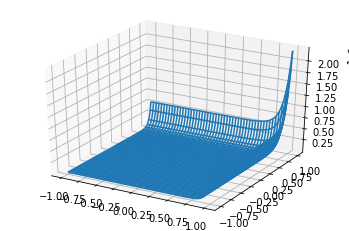

In [7]:
fig1 = plt.figure()
ax = fig1.gca(projection='3d')
#surf = ax.plot_surface(x1v, x2v, y_act, cmap=cm.coolwarm, linewidth=0, antialiased=False)
surf = ax.plot_wireframe(x1v, x2v, y_act)
#ax.set_zlim(-1, 15)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
#fig1.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

This plot shows the input data as red dot and green wirefram plot represent the kriging surrogate generated through Krig class.

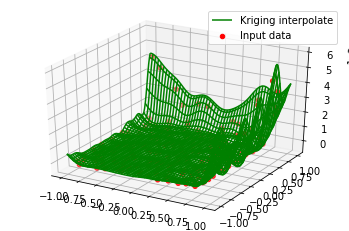

In [8]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# Plot for estimated values
kr = ax.plot_wireframe(x1v, x2v, y, color='Green', label='Kriging interpolate')

# Plot for scattered data
ID = ax.scatter3D(x.samples[:, 0], x.samples[:, 1], np.array(rmodel.qoi_list), color='Red', label='Input data')
plt.legend(handles=[kr, ID])
plt.show()

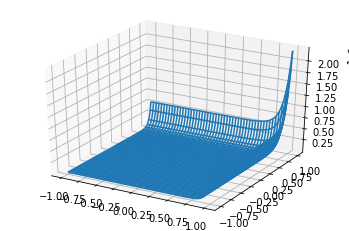

In [9]:
fig2 = plt.figure()
ax1 = fig2.gca(projection='3d')
#surf = ax.plot_surface(x1v, x2v, y_act, cmap=cm.coolwarm, linewidth=0, antialiased=False)
surf = ax1.plot_wireframe(x1v, x2v, y_f)
#ax.set_zlim(-1, 15)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
#fig1.colorbar(surf, shrink=0.5, aspect=5)
plt.show()